In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
snoring_folder = '/content/drive/MyDrive/Snoring Dataset/1'
non_snoring_folder = '/content/drive/MyDrive/Snoring Dataset/0'


In [3]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Function to extract MFCC features from an audio file
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

# Function to load all audio files and extract MFCC features
def load_data(snoring_folder, non_snoring_folder):
    data = []
    labels = []

    # Load snoring files
    for file_name in os.listdir(snoring_folder):
        if file_name.endswith(".wav"):
            file_path = os.path.join(snoring_folder, file_name)
            mfcc = extract_mfcc(file_path)
            data.append(mfcc)
            labels.append('snoring')

    # Load non-snoring files
    for file_name in os.listdir(non_snoring_folder):
        if file_name.endswith(".wav"):
            file_path = os.path.join(non_snoring_folder, file_name)
            mfcc = extract_mfcc(file_path)
            data.append(mfcc)
            labels.append('non-snoring')

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

# Load the dataset
X, y = load_data(snoring_folder, non_snoring_folder)

# Encode labels as numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Print the shape of the data
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (800, 13)
Testing data shape: (200, 13)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Reshape data for LSTM (samples, time_steps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5820 - loss: 1.7226 - val_accuracy: 0.6350 - val_loss: 0.7564
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7016 - loss: 1.0464 - val_accuracy: 0.8000 - val_loss: 0.5215
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7408 - loss: 0.7565 - val_accuracy: 0.9050 - val_loss: 0.2644
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8146 - loss: 0.5242 - val_accuracy: 0.8600 - val_loss: 0.3567
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8101 - loss: 0.4810 - val_accuracy: 0.9250 - val_loss: 0.2075
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8426 - loss: 0.4823 - val_accuracy: 0.9300 - val_loss: 0.2139
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8598 - loss: 0.3347 - val_accuracy: 0.9700 - val_loss: 0.1450
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8831 - loss: 0.2530 - val_accuracy: 0.9500 - val_loss: 0.1574

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y_pred_probs = model.predict(X_test_lstm)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Classification Report:
              precision    recall  f1-score   support

 non-snoring       0.95      0.97      0.96       104
     snoring       0.97      0.95      0.96        96

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



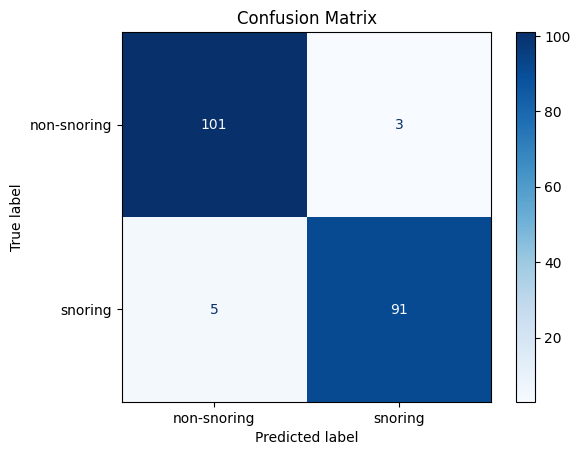

In [7]:
import matplotlib.pyplot as plt
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

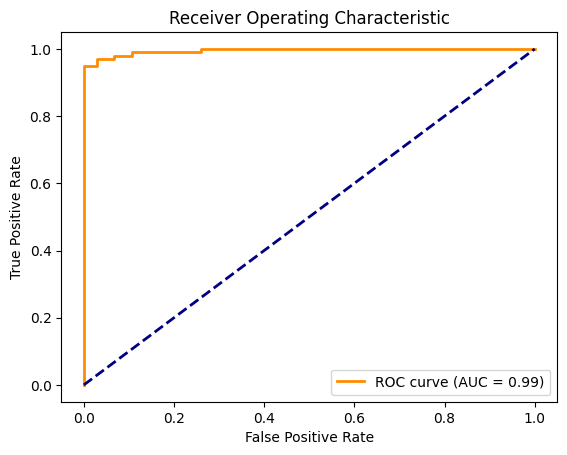

In [9]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [8]:
model.save('snoring_model.h5')

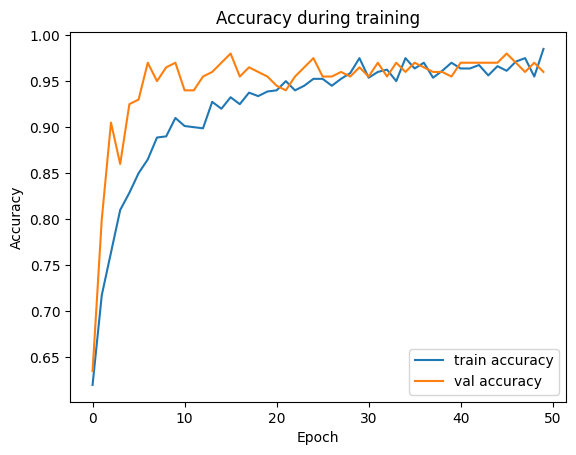

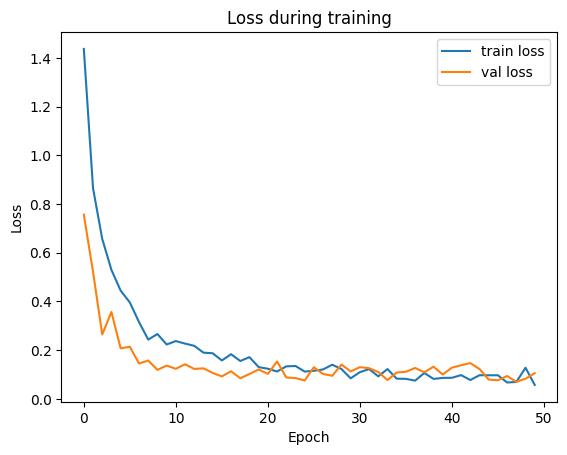

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from google.colab import files

# Upload the audio file
uploaded = files.upload()

# Get the name of the uploaded file
audio_file = list(uploaded.keys())[0]


Saving 0_86.wav to 0_86.wav


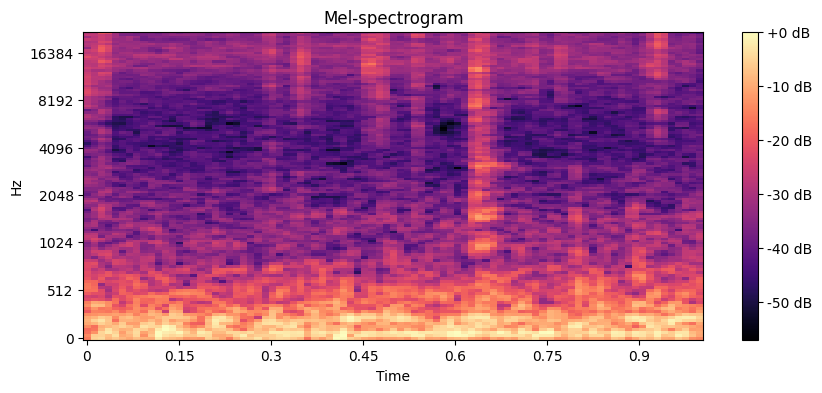

In [ ]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
y, sr = librosa.load(audio_file, sr=None)

# Convert to Mel-spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Display the Mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel-spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()


In [ ]:
import tensorflow as tf

# Load the pre-trained model
model = tf.keras.models.load_model('snoring_model.h5')


In [ ]:
# Reshape the Mel-spectrogram to match the model's input shape
input_data = np.expand_dims(log_mel_spectrogram, axis=0)
input_data = np.expand_dims(input_data, axis=-1)  # Add channel dimension if necessary


In [ ]:
import librosa
import numpy as np

# Load the audio file
y, sr = librosa.load(audio_file, sr=None)

# Extract MFCC features
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract 13 MFCCs
mfccs_mean = np.mean(mfccs, axis=1)  # Calculate mean across frames

# Reshape for the model
input_data = mfccs_mean.reshape(1, 1, 13)  # Reshape to (1, 1, 13)

# Predict using the model
prediction = model.predict(input_data)

# Interpret the prediction
if prediction > 0.5:
    print("The audio is classified as Snoring.")
else:
    print("The audio is classified as Non-Snoring.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
The audio is classified as Non-Snoring.
